# Clustering over INCOME and AGE across the IRIS

## Import

In [1]:
!pip install openpyxl # for pd.read_excel
!pip install ipywidgets # for tqdm.notebook


In [2]:
import numpy as np
import ot    # pip install pot
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import sys
sys.path.append("../src")
from clustering_methods import wbarycenter_clustering_nd
from utils import reconstruct_joint_distribution_ot

from tqdm.notebook import tqdm
import geopandas as gpd


### Income Deciles per IRIS

In [3]:
# INCOME DECILES PER IRIS

# Load the file
df_income_temp = pd.read_csv('../data/BASE_TD_FILO_DEC_IRIS_2020.csv', sep=';', decimal=',')


# Decile columns
decile_cols = ['DEC_D120', 'DEC_D220', 'DEC_D320', 'DEC_D420', 'DEC_MED20', 'DEC_D620', 'DEC_D720', 'DEC_D820', 'DEC_D920']

# Convert from object to float64
df_income_temp[decile_cols] = df_income_temp[decile_cols].apply(pd.to_numeric, errors='coerce')

# Remove the 1319 rows with missing deciles
df_income = df_income_temp.dropna(subset=decile_cols).reset_index(drop=True)

distributions = df_income[decile_cols].to_numpy()

# Useful 
support = np.arange(1, 10)  # D1 to D9
colors = ['cornflowerblue', 'forestgreen', 'red', 'deeppink', 'orange', 'brown', 'purple']
age_groups = ["0_17", "18_29", "30_39", "40_49", "50_64", "65_74", "75P"]


n_distributions = distributions.shape[0]

### Average Income per age

In [4]:
# AVERAGE INCOME PER AGE

# Load the file
df_income_age = pd.read_excel("../data/reve-niv-vie-individu-age-med.xlsx", skiprows=3)


In [5]:
# Keep only the 2020 column
df_income_age = df_income_age[["Tranche d’âge", '2020³ ⁴']]

# Rename the column
df_income_age = df_income_age.rename(columns={'2020³ ⁴': "MEDIAN_INCOME"})

# Rename the age groups
renaming_dict = {
    "Moins de 18 ans": "0_17",
    "De 18 à 29 ans": "18_29",
    "De 30 à 39 ans": "30_39",
    "De 40 à 49 ans": "40_49",
    "De 50 à 64 ans": "50_64",
    "De 65 à 74 ans": "65_74",
    "75 ans et plus": "75P"
}
df_income_age["AGE_GROUP"] = df_income_age["Tranche d’âge"].replace(renaming_dict)

# Get rid of the metadata lines
df_income_age = df_income_age[df_income_age['AGE_GROUP'].isin(age_groups)].reset_index(drop=True)

# Keep only the relevant columns
df_income_age = df_income_age[["AGE_GROUP", "MEDIAN_INCOME"]]


### Population per age 

To apply our algorithms using income by age group, we need to estimate the population in each corresponding age range for every IRIS. However, the INSEE population dataset provides age groupings that do not match exactly with those used in the national income-by-age statistics. To reconcile the two, we reconstruct the target age groups — (0–17), (18–29), (30–39), (40–49), (50–64), (65–74), and 75+ — by combining and subtracting available groups from the population dataset. In some cases, we rely on approximations (e.g., estimating the 45–54 group to split 40–49 and 50–64) to ensure consistency with the income data structure. This harmonization step is essential to later compute joint distributions of age and income at the IRIS level.

In [6]:
# POPULATION PER AGE

# Load the Excel sheet
df_pop_temp = pd.read_excel("../data/base-ic-evol-struct-pop-2020.xlsx", sheet_name=0, skiprows=5)


In [7]:
# Directly accessible age groups
df_pop_temp["AGE_0_17"] = df_pop_temp["P20_POP0002"] + df_pop_temp["P20_POP0305"] + df_pop_temp["P20_POP0610"] + df_pop_temp["P20_POP1117"]
df_pop_temp["AGE_18_29"] = df_pop_temp["P20_POP0014"] + df_pop_temp["P20_POP1529"] - df_pop_temp["AGE_0_17"]
df_pop_temp["AGE_30_39"] = df_pop_temp["P20_POP2539"] + df_pop_temp["P20_POP1824"] - df_pop_temp["AGE_18_29"]
df_pop_temp["AGE_65_74"] = df_pop_temp["P20_POP65P"] - df_pop_temp["P20_POP75P"]
# No processing needed for 75+ age group

# Approximation of the 45–54 group to help deduce 40–49 and 50–64
df_pop_temp["AGE_45_54"] = (
    df_pop_temp["AGE_0_17"] + df_pop_temp["P20_POP1824"] + df_pop_temp["P20_POP2539"] + df_pop_temp["P20_POP4054"]
    - (df_pop_temp["P20_POP0014"] + df_pop_temp["P20_POP1529"] + df_pop_temp["P20_POP3044"])
)

# Approximate 40–49 from 40–54 and part of 45–54
df_pop_temp["AGE_40_49"] = df_pop_temp["P20_POP4054"] - 0.5 * df_pop_temp["AGE_45_54"]

# Approximate 50–64 from 55–64 and part of 45–54
df_pop_temp["AGE_50_64"] = df_pop_temp["P20_POP5564"] + 0.5 * df_pop_temp["AGE_45_54"]

# Renaming for clarity
df_pop_temp["0_17"] = df_pop_temp["AGE_0_17"]
df_pop_temp["18_29"] = df_pop_temp["AGE_18_29"]
df_pop_temp["30_39"] = df_pop_temp["AGE_30_39"]
df_pop_temp["40_49"] = df_pop_temp["AGE_40_49"]
df_pop_temp["50_64"] = df_pop_temp["AGE_50_64"]
df_pop_temp["65_74"] = df_pop_temp["AGE_65_74"]
df_pop_temp["75P"] = df_pop_temp["P20_POP75P"]

# Final columns to keep
final_cols = ["IRIS", "REG", "DEP", "LIBCOM", "LIBIRIS"] + age_groups

df_pop = df_pop_temp[final_cols]


## Joint Age-Income Distributions

### Reconstructing the joint age–income distribution

For each IRIS, we reconstruct a joint probability distribution π over age groups and income levels. The marginal distributions are:
* the age distribution of the IRIS (based on population counts per age group), and
* a uniform distribution over the income deciles observed in the IRIS.

We use optimal transport to find the coupling π that best aligns the income levels with the national average income for each age group, minimizing the cost:

$$
C_{i,j} = |R_j - m(T_i)|
$$

where $R_j$ is the j-th income level (decile), and $m(T_i)$ is the national average income for age group $T_i$.

The result is a joint distribution π (a matrix), interpreted as the most plausible alignment between age and income in the IRIS, under minimal deviation from national trends.

### Computation for Each IRIS

In [9]:
# Compute national median income per age group
age_income_medians = df_income_age.set_index("AGE_GROUP").loc[age_groups, "MEDIAN_INCOME"].to_numpy()

# Find common IRIS identifiers present in both datasets
common_iris = sorted(set(df_income["IRIS"]).intersection(df_pop["IRIS"]))

# Compute joint distributions
joint_distributions = []
iris_ids = []

for iris in tqdm(common_iris):
    row_income = df_income[df_income["IRIS"] == iris]
    row_pop = df_pop[df_pop["IRIS"] == iris]

    if row_income.empty or row_pop.empty:
        continue  # Skip if data is missing for this IRIS

    # Age group weights (normalized)
    age_counts = row_pop.iloc[0][age_groups].to_numpy()
    age_weights = age_counts / age_counts.sum()

    # Income decile values
    income_deciles = row_income.iloc[0][decile_cols].to_numpy()

    # Compute the joint distribution π using optimal transport
    pi = reconstruct_joint_distribution_ot(age_weights, income_deciles, age_income_medians)

    joint_distributions.append(pi)
    iris_ids.append(iris)

# Stack the joint distributions into a 3D array: (n_iris, n_age_groups, n_income_deciles)
joint_distributions = np.stack(joint_distributions)


  0%|          | 0/14703 [00:00<?, ?it/s]

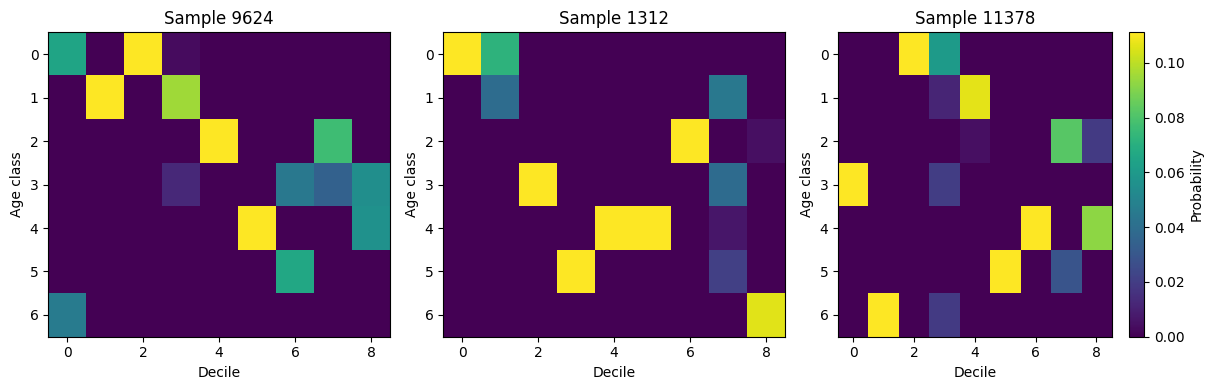

In [40]:
# Plot random joint distributions
rng = np.random.default_rng(42)
indices = rng.choice(len(joint_distributions), size=3, replace=False)

plt.figure(figsize=(12, 4))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(joint_distributions[indices[i]], cmap='viridis', aspect='auto')
    plt.title(f"Sample {indices[i]}")
    plt.xlabel("Decile")
    plt.ylabel("Age class")

plt.tight_layout()
plt.colorbar(label="Probability")
plt.show()

* **`a`** est un vecteur de taille $n$ tel que $a_i\ge0$ et $\sum_i a_i = 1$. Il représente la **marge** de la première loi discrète sur son support indexé par $i$.
* **`b`** est un vecteur de taille $m$ tel que $b_j\ge0$ et $\sum_j b_j = 1$. Il représente la **marge** de la seconde loi discrète sur son support indexé par $j$.
* **`M`** est une matrice de taille $n\times m$ (ou $n\times n$ si les deux lois partagent le même support) dont l’entrée $M[i,j]$ est le **coût unitaire** pour transporter **une unité de masse** du point $i$ de la loi 1 vers le point $j$ de la loi 2.

Quand tu appelles :

```python
cost = ot.emd2(a, b, M)
```

le solver résout le problème de Kantorovich :

$$
\min_{\pi\in\mathbb R_+^{n\times m}}
\sum_{i=1}^n\sum_{j=1}^m \pi_{ij}\,M_{ij}
\quad\text{tel que}\quad 
\sum_j \pi_{ij} = a_i,\;
\sum_i \pi_{ij} = b_j.
$$

* La contrainte $\sum_j \pi_{ij}=a_i$ garantit que la première marginale de $\pi$ est $a$.
* La contrainte $\sum_i \pi_{ij}=b_j$ garantit que la seconde marginale de $\pi$ est $b$.
* Le résultat `cost` est le **coût minimal total** du transport optimal entre ces deux lois.

En résumé, **`ot.emd2(a, b, M)`** te donne la distance de Wasserstein (avec coût $M$) entre deux distributions représentées par leurs poids `a` et `b` sur leurs supports indexés.


Le point crucial, c’est que **toutes tes joint\_distributions** sont alignées sur le **même schéma discret** (7 tranches d’âge × 9 déciles) — **peu importe** que les vraies valeurs de R₁…R₉ varient d’un IRIS à l’autre, on les indexe toujours par **décile ordinal** (1, 2, …, 9).

---

## 📐 Comment marche la cost‑matrix ?

1. **Support discret commun**
   On ne met pas les valeurs réelles des revenus dans le support de l’OT, on met **l’indice de la tranche** (décile) et **l’indice de la tranche d’âge**.
   → Chaque bin est repéré par son couple **(age\_idx, decile\_idx)**.

2. **Coordonnées du support**

   ```python
   coords = [(i,j) for i in range(n_ages) for j in range(n_deciles)]
   ```

   C’est le même pour tous les IRIS, donc on peut calculer une **cost\_matrix unique** :

   ```python
   cost_matrix = ot.dist(coords, coords)  # euclidean distance entre bins
   ```

3. **Interprétation**

   * Transporter 1 unité de masse du bin (i,j) vers (i′,j′) coûte la distance euclidienne entre (i,j) et (i′,j′) dans le **couple d’indices**.
   * On ignore ici les écarts en euros réels, on traite le positionnement ordinal comme proxy.

---

## 🎯 Pourquoi c’est acceptable

* **Alignement des supports** : tous les $\pi$ ont la même dimension $(7\times9)$, on peut les comparer.
* **Distance “moyenne”** : on mesure à quel point les formes de lois jointe diffèrent en décalages d’âge vs décile ordinal, ce qui capture les transitions d’une tranche à l’autre.

---

## 🚀 Si tu veux incorporer les **valeurs réelles** de revenu

Tu peux passer dans un espace continu **2D** :

* Coordonnée d’un bin = $(\text{m}(T_i), R_j)$
* Alors

  ```python
  coords = np.array([
    (income_median_by_age[i], income_values[j])
    for i in range(n_ages)
    for j in range(n_deciles)
  ])
  cost_matrix = ot.dist(coords, coords)
  ```
* Là tu prends en compte **l’écart réel en euros** entre un bin et un autre.

---

### En résumé

* **Le code original** utilise le même support discret pour tous les IRIS (déciles ordinales), d’où la cost\_matrix unique.
* **Pour inclure les vraies valeurs R\_i**, il faut remplacer `coords = [(i,j)]` par `coords = [(m(T_i), R_j)]`, et tu gardes un seul cost\_matrix partagé.

Cela te permettra de mesurer un vrai coût monétaire *et* d’âge dans le même OT, sans perdre l’alignement des supports.


In [54]:
n_clusters = 2
reg=1e-1
rng = np.random.default_rng(42)
n_samples = joint_distributions.shape[0]

barycenters = joint_distributions[rng.choice(n_samples, size=n_clusters, replace=False)]

shape = joint_distributions.shape[1:]
n_bins = np.prod(shape)

# Flatten distributions and barycenters
data_flat = joint_distributions.reshape(n_samples, n_bins)
bary_flat = np.stack([b.reshape(n_bins) for b in barycenters], axis=0)

# Normalize to ensure each is a proper probability mass
data_flat /= data_flat.sum(axis=1, keepdims=True)
bary_flat /= bary_flat.sum(axis=1, keepdims=True)

coords = np.array([(i, j) for i in range(shape[0]) for j in range(shape[1])])
cost_matrix = ot.dist(coords, coords)

assignments = np.zeros(n_samples, dtype=int)

for i in tqdm(range(n_samples), desc="Assigning to barycenters"):
    distances = np.zeros(n_clusters, dtype=float)
    for j in range(n_clusters):
        distances[j] = ot.emd2(data_flat[i], bary_flat[j], cost_matrix)
    assignments[i] = np.argmin(distances)

Assigning to barycenters:   0%|          | 0/14703 [00:00<?, ?it/s]

In [52]:
for i in range(n_clusters):
    print(len(np.where(assignments == i)[0]))

2471
12232


In [56]:
new_barycenters = []
for k in tqdm(range(n_clusters), desc="Recomputing barycenters"):
    # Select all members of cluster k
    members = joint_distributions[assignments == k]

    # If the cluster is empty, reinitialize with a random sample
    if len(members) == 0:
        idx = rng.integers(0, joint_distributions.shape[0])
        new_barycenters.append(joint_distributions[idx])
        continue 

    # Flatten and transpose to get shape (n_bins, n_members)
    A = members.reshape(len(members), n_bins).T

    # Compute the (unregularized) Wasserstein barycenter
    bary_flat = ot.bregman.barycenter(A, cost_matrix, reg)

    # Reshape back to 2D (n_age, n_decile)
    new_barycenters.append(bary_flat.reshape(shape))


Recomputing barycenters:   0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
"""
assignments, barycenters = wbarycenter_clustering_nd(
    data=joint_distributions,  # (n_iris, 7, 9)
    n_clusters=3,
    n_iter=5,
    reg=0.1
)
"""


'\nassignments, barycenters = wbarycenter_clustering_nd(\n    data=joint_distributions,  # (n_iris, 7, 9)\n    n_clusters=3,\n    n_iter=5,\n    reg=0.1\n)\n'

In [57]:
for i, b in enumerate(barycenters):
    print(f"--- Barycentre {i} ---")
    print(f"Shape: {b.shape}")
    print(f"Min: {b.min():.2e}")
    print(f"Max: {b.max():.2e}")
    print(f"Sum: {b.sum():.6f}")
    print(f"Contains NaN: {np.isnan(b).any()}")
    print(f"Zero elements: {np.sum(b == 0)} / {b.size}")
    print()


--- Barycentre 0 ---
Shape: (7, 9)
Min: 0.00e+00
Max: 1.11e-01
Sum: 1.000000
Contains NaN: False
Zero elements: 48 / 63

--- Barycentre 1 ---
Shape: (7, 9)
Min: 0.00e+00
Max: 1.11e-01
Sum: 1.000000
Contains NaN: False
Zero elements: 48 / 63



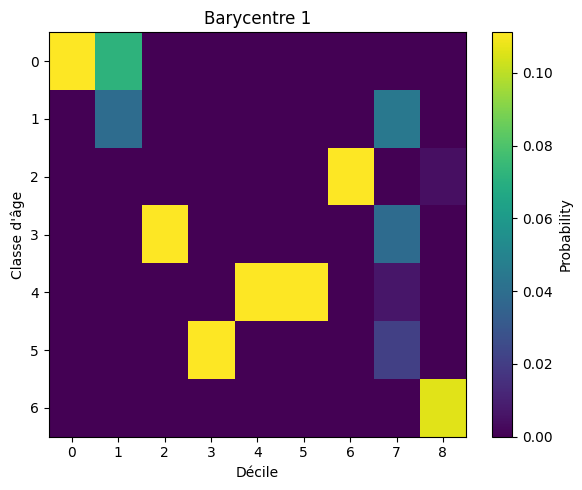

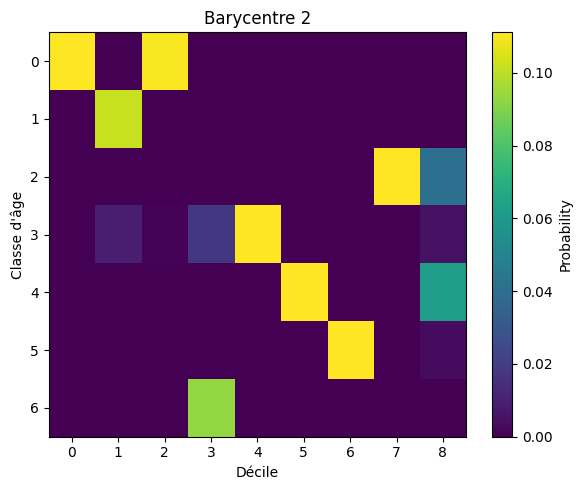

In [58]:
for i, barycenter in enumerate(barycenters):
    plt.figure(figsize=(6, 5))
    plt.imshow(barycenter, cmap='viridis', aspect='auto')
    plt.colorbar(label="Probability")
    plt.title(f"Barycentre {i+1}")
    plt.xlabel("Décile")
    plt.ylabel("Classe d'âge")
    plt.tight_layout()
    plt.show()
